## 05. cgan for dataimpurity.csv with minmax scaler

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler

import os

### Importing data/basic viz

In [3]:
# DATA_FOLDER = "AirQualityUCI"
# DATA_FILE = "AirQualityUCI.csv"
#path = os.path.join('',DATA_FOLDER, DATA_FILE)
# load csv into df
df = pd.read_csv(r'/Users/emilymiura/dowgan-ems/notebooks/ems-experiments/dataimpurity.csv', 
                 delimiter='\t')
#                 parse_dates=[['Date', 'Time']],
#                 decimal=',')



In [5]:
#Shape of data
print(f'shape of data: {df.shape}')

#Dropping date column and putting column names in a list bc they are so long
data = df.drop(df.columns[0],axis=1)
time = np.arange(0,len(data))
data.insert(0,'Time',time)

#List of all the column names
list_colnames=list(data)
print(f"shape of data after removing date column and adding time: {data.shape}")
print(f"number of columns: {len(data.columns)}")

shape of data: (10177, 47)
shape of data after removing date column and adding time: (10177, 47)
number of columns: 47


In [11]:
data.head()

,Time,x1:Primary Column Reflux Flow,x2:Primary Column Tails Flow,x3:Input to Primary Column Bed 3 Flow,x4:Input to Primary Column Bed 2 Flow,x5:Primary Column Feed Flow from Feed Column,x6:Primary Column Make Flow,x7:Primary Column Base Level,x8:Primary Column Reflux Drum Pressure,x9:Primary Column Condenser Reflux Drum Level,...,x37: Feed Column Tails Flow to Primary Column,x38: Feed Column Calculated DP,x39: Feed Column Steam Flow,x40: Feed Column Tails Flow,Avg_Reactor_Outlet_Impurity,Avg_Delta_Composition Primary Column,y:Impurity,Primary Column Reflux/Feed Ratio,Primary Column Make/Reflux Ratio,Class
0,0,327.812988,45.792000,2095.060059,2156.010010,98.500504,95.467400,54.347599,41.012100,52.235298,...,45.008499,66.660400,8.68813,99.961403,5.38024,1.49709,1.77833,3.32803,0.291226,2
1,1,322.970001,46.164299,2101.000000,2182.899902,98.001404,94.967300,54.224701,41.007599,52.537800,...,45.008499,66.549599,8.70683,99.863701,5.33345,1.51392,1.76964,3.29556,0.294044,2
2,2,319.674011,45.992699,2102.959961,2151.389893,98.822899,96.078499,54.612999,41.045101,52.015900,...,45.008499,66.059898,8.69269,100.249000,5.37677,1.50634,1.76095,3.23481,0.300552,2
3,3,327.222992,46.096001,2101.370117,2172.139893,98.773300,96.122299,54.915298,41.040501,52.947701,...,45.008499,67.969704,8.70482,100.320000,5.32315,1.47935,1.75226,3.31287,0.293752,2
4,4,331.177002,45.849300,2114.060059,2157.770020,99.323097,94.752098,54.092499,40.993401,53.050701,...,45.008499,67.645401,8.70077,100.658997,5.28227,1.44489,1.74357,3.33435,0.286107,2


In [7]:
#Counting the number of null values in each column
na_vals = []
for x in np.arange(0,len(list_colnames)):
    na_vals.append(data[list_colnames[x]].isnull().sum())

na_vals_dict = dict(zip(np.arange(0,len(list_colnames)),na_vals))
print(na_vals_dict)

{0: 0, 1: 1, 2: 2, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0, 15: 2, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 1, 24: 1, 25: 0, 26: 0, 27: 1, 28: 0, 29: 1, 30: 0, 31: 0, 32: 0, 33: 0, 34: 1, 35: 0, 36: 0, 37: 0, 38: 1, 39: 0, 40: 1, 41: 94, 42: 287, 43: 0, 44: 1, 45: 1, 46: 0}


In [8]:
def plot_dataframe(dataframe: pd.DataFrame,
                    x: str,
                    y: str,
                    title: str):
    """plots first 100 values from selected x and y columns of AirQuality dataframe"""
    plt.plot(dataframe[x][:500], dataframe[y][:500], label=y)
    #plt.xticks(dataframe[x][:500][0::10],
    #            rotation=45,
    #            ha='right')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)

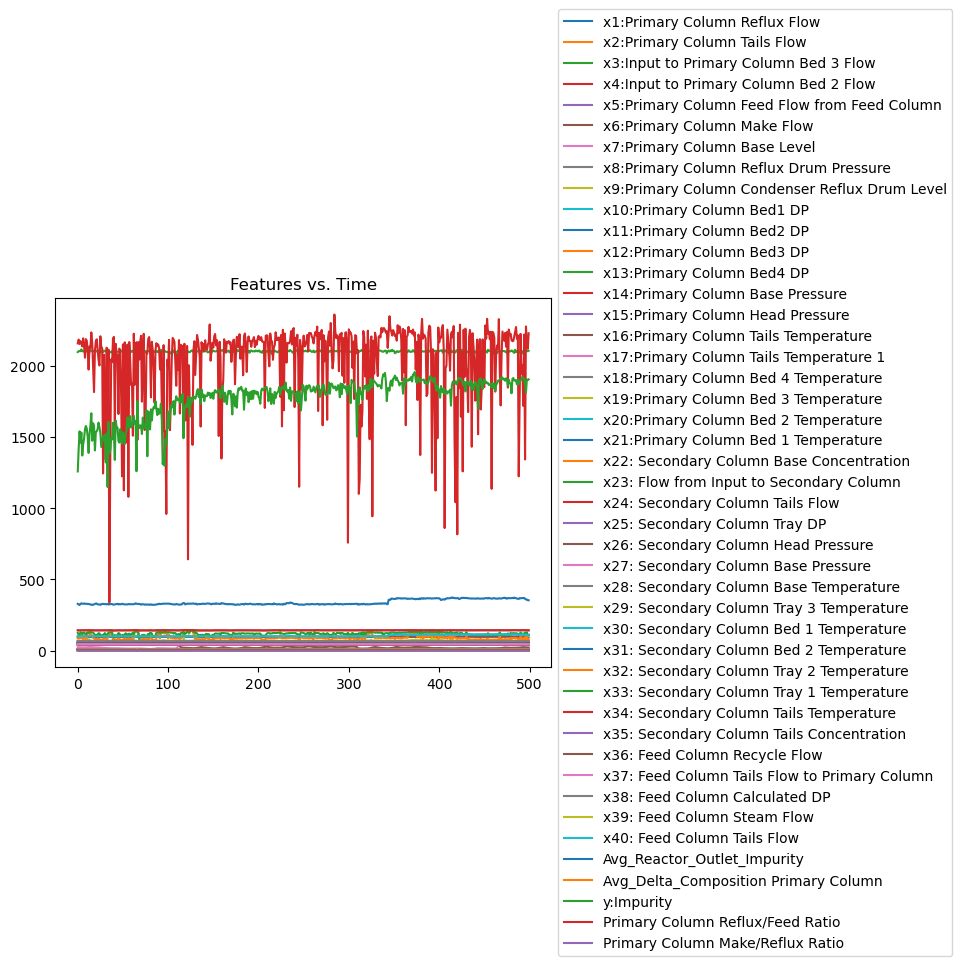

In [9]:
for i, column in enumerate(data.columns[1:]):
    if column == 'Class':
        break
    plot_dataframe(dataframe=data,
                   x='Time',
                   y=column,
                   title="Features vs. Time")

### Splitting data into target and conditions and performing MinMax scaling on target data

In [20]:
# splitting data into target and conditions data
target_data = data.iloc[:,1:46]
print(f"shape of target_tensor (all features): {target_data.shape}")

conditions_data = data['Class'].values.reshape(-1,1)
print(f"shape of conditions_tensor (operating conditions): {conditions_data.shape}")

shape of target_tensor (all features): (10177, 45)
shape of conditions_tensor (operating conditions): (10177, 1)


In [33]:
# performing MinMax scaling
scaler = MinMaxScaler(feature_range=(-1,1))

# fit & transform scaler data
targets = scaler.fit_transform(target_data)

column_names = list(data.columns.values[1:46])
target_data_scaled = pd.DataFrame(targets, columns=column_names)

In [34]:
target_data_scaled.head()

,x1:Primary Column Reflux Flow,x2:Primary Column Tails Flow,x3:Input to Primary Column Bed 3 Flow,x4:Input to Primary Column Bed 2 Flow,x5:Primary Column Feed Flow from Feed Column,x6:Primary Column Make Flow,x7:Primary Column Base Level,x8:Primary Column Reflux Drum Pressure,x9:Primary Column Condenser Reflux Drum Level,x10:Primary Column Bed1 DP,...,x36: Feed Column Recycle Flow,x37: Feed Column Tails Flow to Primary Column,x38: Feed Column Calculated DP,x39: Feed Column Steam Flow,x40: Feed Column Tails Flow,Avg_Reactor_Outlet_Impurity,Avg_Delta_Composition Primary Column,y:Impurity,Primary Column Reflux/Feed Ratio,Primary Column Make/Reflux Ratio
0,-0.216799,-0.939640,0.300192,0.377471,-0.227470,0.480052,0.272795,0.445359,0.342283,-0.656854,...,-0.635226,0.332837,-0.732883,-0.292201,-0.246678,-0.149221,0.117791,-0.595807,-0.426793,0.795852
1,-0.266143,-0.819147,0.303879,0.394645,-0.242686,0.472292,0.264695,0.444358,0.349876,-0.678563,...,-0.659230,0.332837,-0.738948,-0.220049,-0.249754,-0.156620,0.129952,-0.597783,-0.457392,0.813240
2,-0.299724,-0.874685,0.305095,0.374520,-0.217641,0.489533,0.290287,0.452696,0.336775,-0.672439,...,-0.657088,0.332837,-0.765755,-0.274609,-0.237625,-0.149770,0.124475,-0.599758,-0.514642,0.853397
3,-0.222810,-0.841251,0.304109,0.387773,-0.219154,0.490213,0.310211,0.451673,0.360166,-0.647116,...,-0.651512,0.332837,-0.661210,-0.227806,-0.235390,-0.158249,0.104972,-0.601733,-0.441080,0.811438
4,-0.182524,-0.921095,0.311984,0.378595,-0.202392,0.468953,0.255982,0.441201,0.362752,-0.655071,...,-0.649812,0.332837,-0.678962,-0.243430,-0.224719,-0.164713,0.080071,-0.603708,-0.420837,0.764265


### Putting data into tensors 

In [36]:
# converting target and conditions into tensors
target_tensor = torch.tensor(target_data_scaled.values, dtype=torch.float32)
print(f"shape of target_tensor (all features): {target_tensor.shape}")

conditions_tensor = torch.tensor(conditions_data, dtype=torch.float32)
print(f"shape of conditions_tensor (operating conditions): {conditions_tensor.shape}")

# print(f'first timepoint (row): {target_tensor[0]}')
# print(f'first feature (col): {target_tensor[:,0]}')

shape of target_tensor (all features): torch.Size([10177, 45])
shape of conditions_tensor (operating conditions): torch.Size([10177, 1])


### Batching data

We are aiming for a list of tensors (target_tensor_list and condition_tensor_list) that have shapes:
* `target_tensor_list = [368, 24, 45]`
* `conditions_tensor_list = [368, 24, 1]`
* where the shape is [`N_SAMPLES`, `N_DATAPOINTS`, `N_FEATURES`]

we are also REMOVING any days with NaN values present

In [42]:
# Included step where is there is a nan value to not include it in the final tensor list
# Not sure if this is how we want to do this rn but an idea.

# Data is taken per hour - splitting up batches into "days" of data
# N_SAMPLES = 10177 // 24 = 424 DAYS of data where each CHUNK (i.e. 24 datapoints) is 1 DAY

N_SAMPLES = 424
N_DATAPOINTS = data.shape[0]//N_SAMPLES

target_tensor_list = []
conditions_tensor_list = []
invalid_batch_indexes = []

#Iterating through all of the data and dividing it up
for i in np.arange(0, N_SAMPLES, 1):
    
    #Taking a batch of the target data
    a = torch.split(target_tensor, N_DATAPOINTS, dim=0)[i]
    #Checking for any NaNs in that tensor
    # if its true, not saving it and the condition tensor to the list
    if torch.isnan(a).any() == True:
        invalid_batch_indexes.append(i)
        continue
    else:
        target_tensor_list.append(a)

    #Taking the corresponding batch of conditions
    b = torch.split(conditions_tensor, N_DATAPOINTS, dim=0)[i]
    conditions_tensor_list.append(b)

print(f'length of data: {data.shape[0]}')
print(f'We have {len(target_tensor_list)} samples with {N_DATAPOINTS} datapoints in each.')
print(f'There are {len(invalid_batch_indexes)} invalid batches.')

length of data: 10177
We have 368 samples with 24 datapoints in each.
There are 56 invalid batches.


In [47]:
#Confirming # of tensors and condition lists
#Confirming that the last batch has 101 points (not truncating)
print(f'length of target: {len(target_tensor_list)}')
print(f'length of conditions: {len(conditions_tensor_list)}')
print(f'shape of last target tensor: {target_tensor_list[len(target_tensor_list)-1].shape}')
print(f'shape of last condition tensor: {conditions_tensor_list[len(target_tensor_list)-1].shape}')


length of target: 368
length of conditions: 368
shape of last target tensor: torch.Size([24, 45])
shape of last condition tensor: torch.Size([24, 1])


In [48]:
# making a custom dataset class
class ImpuritiesDataset(Dataset):
    def __init__(self, target, conditions):
        self.target = target
        self.conditions = conditions
    def __len__(self):
        return len(self.conditions)
    def __getitem__(self, idx):
        condition = self.conditions[idx]
        target = self.target[idx]
        return target, condition

In [49]:
#Inputting data into AirQualityDataset class
train_data = ImpuritiesDataset(target=target_tensor_list,
                               conditions=conditions_tensor_list)
target, condition = next(iter(train_data))[0], next(iter(train_data))[1]
print(target.shape)
print(condition.shape)

torch.Size([24, 45])
torch.Size([24, 1])


### Inputting Data into dataloader

In [56]:
from torch.utils.data import DataLoader

BATCH_SIZE = 20

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

print(f"dataloader: {train_dataloader}")
print(f"length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} (batch_size) examples")
print(f"number of total examples: {len(train_data)} \neach example containing... \nTARGET shape (number of timepoints): {train_data[0][0].shape} \nCONDITION shape (class 1 or 2): {train_data[0][1].shape}")

dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7fcb10ba2f40>
length of train_dataloader: 19 batches of 20 (batch_size) examples
number of total examples: 368 
each example containing... 
TARGET shape (number of timepoints): torch.Size([24, 45]) 
CONDITION shape (class 1 or 2): torch.Size([24, 1])


In [58]:
# # for loop to check the size of batch in the dataloader
# # BATCH NUMBER 18 is SMALLER -> it is left out of the training loop
# for i, (target, condition) in enumerate(train_dataloader):
#     print(i, len(condition))

### Running 1 batch of targets and conditions through test layers

In [61]:
train_target_batch, train_condition_batch = next(iter(train_dataloader))
print(f"training target batch size: {train_target_batch.shape}")
print(f"training condition batch: {train_condition_batch.shape}")

training target batch size: torch.Size([20, 24, 45])
training condition batch: torch.Size([20, 24, 1])


In [62]:
# concatening batched data together for forward pass
train_input_batch = torch.cat([train_target_batch, train_condition_batch], axis=2)
print(train_input_batch.shape)

# transposing concatenated data for input into conv1d layer [batchsize, columns, datapoints]
train_input_batch_transposed = torch.transpose(train_input_batch, 1, 2)
print(train_input_batch_transposed.shape)

torch.Size([20, 24, 46])
torch.Size([20, 46, 24])


In [65]:
# passing through a conv1d layer and a max pool layer - for discriminator
test_conv1d = nn.Conv1d(in_channels=46,
                        out_channels=8,
                        kernel_size=3,
                        stride=1,
                        padding=1)

conv1d_out = test_conv1d(train_input_batch_transposed)
print(conv1d_out.shape)

test_maxpool = nn.MaxPool1d(kernel_size=1, 
                            stride=1, 
                            padding=0)

maxpool_out = test_maxpool(conv1d_out)
print(maxpool_out.shape)

# passing through linear layer
test_linear = nn.Linear(in_features=24, # we want this in_feature to match the maxpool output (hidden units) so we need to tranpose this in_features from 24 -> 8
                        out_features=2)

linear_out = test_linear(maxpool_out)
print(linear_out.shape)

torch.Size([20, 8, 24])
torch.Size([20, 8, 24])
torch.Size([20, 8, 2])


In [66]:
# passing through a convTranpose 1d layer and a batchnorm layer - for generator
test_convTranspose1d = nn.ConvTranspose1d(in_channels=46,
                        out_channels=8,
                        kernel_size=3,
                        stride=1,
                        padding=1)

convTranspose1d_out = test_convTranspose1d(train_input_batch_transposed)
print(convTranspose1d_out.shape)

test_batchnorm = nn.BatchNorm1d(num_features=8)
batchnorm_out = test_batchnorm(convTranspose1d_out)
print(batchnorm_out.shape)

# passing through linear layer
test_linear = nn.Linear(in_features=24, # we want this in_feature to match the batchnorm output (hidden units) so we need to tranpose this in_features from 24 -> 8
                        out_features=2)

linear_out = test_linear(batchnorm_out)
print(linear_out.shape)

torch.Size([20, 8, 24])
torch.Size([20, 8, 24])
torch.Size([20, 8, 2])


### coding discriminator and generator

In [72]:
# defining a disciminator model

from torch import nn

class Discriminator(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        # input shape is number of columns
        # output shape is 2 (for probability of 0 or 1)

        # pass concatenated target+conditions through nn.Sequential
        self.main = nn.Sequential(
            # input is INPUT SHAPE // number of columns/channels
            nn.Conv1d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False),
            nn.MaxPool1d(kernel_size=1,
                         stride=1,
                         padding=0),
            nn.Conv1d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False),
            nn.MaxPool1d(kernel_size=1,
                         stride=1,
                         padding=0))

        self.linearize = nn.Sequential(
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape),
            nn.Tanh() # output of probability: 0 or 1
        )

    def forward(self, target, conditions):
        """takes target and conditions as batches"""
        # concatenating
        data = torch.cat([target, conditions], axis=2)
        #print(f"concatenated: {data.shape}")

        # tranposing
        data_in = torch.transpose(data, 1, 2)
        #print(f"tranposed: {data_in.shape}")

        # forward pass through nn.Main
        out = self.main(data_in)

        # tranposing the data for linear and sigmoid layers
        data_in = torch.transpose(out, 1, 2)
        #print(f"linear transposed: {data_in.shape}")

        # forward pass through nn.linear + nn.sigmoid
        out = self.linearize(data_in)
    
        return out

In [73]:
# defining a generator model

from torch import nn

class Generator(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        # input shape is number of columns
        # output shape is 2 (for probability of 0 or 1)

        # pass concatenated target+conditions through nn.Sequential
        self.main = nn.Sequential(
            # input is INPUT SHAPE // number of columns/channels
            nn.ConvTranspose1d(in_channels=input_shape,
                               out_channels=hidden_units,
                               kernel_size=3,
                               stride=1,
                               padding=1),
            nn.BatchNorm1d(num_features=hidden_units),
            nn.ConvTranspose1d(in_channels=hidden_units,
                               out_channels=hidden_units,
                               kernel_size=3,
                               stride=1,
                               padding=1),
            nn.BatchNorm1d(num_features=hidden_units)

    	)

        self.linearize = nn.Sequential(
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )

    def forward(self, noise, conditions):
        """takes target and conditions as batches"""
        # concatenating
        data = torch.cat([noise, conditions], axis=2)
        #print(f"concatenated: {data.shape}")

        # tranposing
        data_in = torch.transpose(data, 1, 2)
        #print(f"tranposed: {data_in.shape}")

        # forward pass through nn.Main
        out = self.main(data_in)

        # tranposing the data for linear and sigmoid layers
        data_in = torch.transpose(out, 1, 2)
        #print(f"linear transposed: {data_in.shape}")

        # forward pass through nn.linear + nn.sigmoid
        out = self.linearize(data_in)
    
        return out

In [74]:
# input shape is number of channels (X features), target+conditions columns
# output shape is number of probabilities (0, 1 for true or false)
netD = Discriminator(input_shape=46, hidden_units=8, output_shape=2)
netD

Discriminator(
  (main): Sequential(
    (0): Conv1d(46, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (linearize): Sequential(
    (0): Linear(in_features=8, out_features=2, bias=True)
    (1): Tanh()
  )
)

In [75]:
netG = Generator(input_shape=46, hidden_units=8, output_shape=45)
netG

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(46, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConvTranspose1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linearize): Sequential(
    (0): Linear(in_features=8, out_features=45, bias=True)
  )
)

In [76]:
noise = torch.randn((BATCH_SIZE, 24, 45))
noise.shape # inputting random data same shape as original targets

torch.Size([20, 24, 45])

In [77]:
loss_D_list = []
loss_G_list = []

epochs = 50

netD.train()
netG.train()

# optimizer for discriminator and generator
optimizerD = torch.optim.Adam(netD.parameters(),lr=0.001,betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(),lr=0.001,betas=(0.5, 0.999))


real_condition = torch.ones([BATCH_SIZE, len(condition[0]), 1], dtype=torch.float)
#print(f"real condition shape: {real_condition.shape}")
fake_condition = torch.zeros([BATCH_SIZE, len(condition[0]), 1], dtype=torch.float)
#print(f"fake condition shape: {fake_condition.shape}")

loss_fn = nn.MSELoss()

#Iterating through epochs
#for epoch in tqdm(range(epochs)):
for epoch in range(epochs):

	#Iterating through batches (i: iterable int, target: target, condition: condition)
    for i, (target, condition) in enumerate(train_dataloader):

        # for iterating through only FULL BATCHES
        if len(condition) == BATCH_SIZE:
            #print(f"BATCH {i}")

            # initializng fixed noise to generator
            fixed_noise = torch.randn((BATCH_SIZE, 24, 45))
            #print(f"fixed noise shape: {fixed_noise.shape}")

            '''
                Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            '''
            #Generating data and feeding it to the discriminator
            #print(f"condition shape: {condition.shape}")
            G_result = netG(fixed_noise,condition)
            #print(f"G_result shape: {G_result.shape}")
            D_fake_result = netD(G_result,condition)
            #print(f"D_fake_result shape: {D_fake_result.shape}")

            #Inputting real results into discriminator
            D_real_result = netD(target, condition)
            #print(f"D_real_result shape: {D_real_result.shape}")

            #Calculating the loss for the real and the generated data
            D_real_loss = loss_fn(D_real_result, real_condition)
            #print(f"D_real_loss: {D_real_loss}")
            D_fake_loss = loss_fn(D_fake_result, fake_condition)
            #print(f"D_fake_loss: {D_fake_loss}")

            # Back propagation
            D_train_loss = (D_real_loss + D_fake_loss) / 2
            #print(f"D_train_loss: {D_train_loss}")
            loss_D_list.append(D_train_loss)
            netD.zero_grad()
            D_train_loss.backward()
            optimizerD.step()
            '''
                Update G network: maximize log(D(G(z)))
            '''
            new_condition = torch.LongTensor(BATCH_SIZE, 24, 1).random_(1, 2)
            #print(f"new_condition shape: {new_condition.shape}")
            # new_embed = new_condition[:,0].view(-1)
            # print(f"new_embed shape: {new_embed.shape}")
            G_result = netG(fixed_noise, new_condition)
            #print(f"G_result shape: {G_result.shape}")
            D_fake_result = netD(G_result, new_condition)
            #print(f"D_fake_result shape: {D_fake_result.shape}")
            G_train_loss = loss_fn(D_fake_result, real_condition)
            #print(f"G_train_loss: {G_train_loss}")
            loss_G_list.append(G_train_loss)

            # Back propagation
            netD.zero_grad()
            netG.zero_grad()
            G_train_loss.backward()
            optimizerG.step()
        else:
            pass

    if (epoch+1) % 10 == 0:
                print(f"Epoch: {epoch+1} | D_loss: {D_train_loss:.4f} | G_loss: {G_train_loss:.4f}")
    else:
          pass

/Users/emilymiura/opt/anaconda3/envs/dowgan/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([20, 24, 1])) that is different to the input size (torch.Size([20, 24, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 10 | D_loss: 0.1353 | G_loss: 0.5093
Epoch: 20 | D_loss: 0.4636 | G_loss: 0.3795
Epoch: 30 | D_loss: 0.3733 | G_loss: 0.2202
Epoch: 40 | D_loss: 0.3038 | G_loss: 0.2971
Epoch: 50 | D_loss: 0.3182 | G_loss: 0.2660


In [78]:
# converting loss lists to numpy
D_loss = []
G_loss = []
for i, loss in enumerate(loss_D_list):
    d = loss.detach().numpy()
    D_loss.append(d)
for i, loss in enumerate(loss_G_list):
    g = loss.detach().numpy()
    G_loss.append(g)

# stacking arrays
D_loss_array = np.vstack(D_loss).flatten()
G_loss_array = np.vstack(G_loss).flatten()


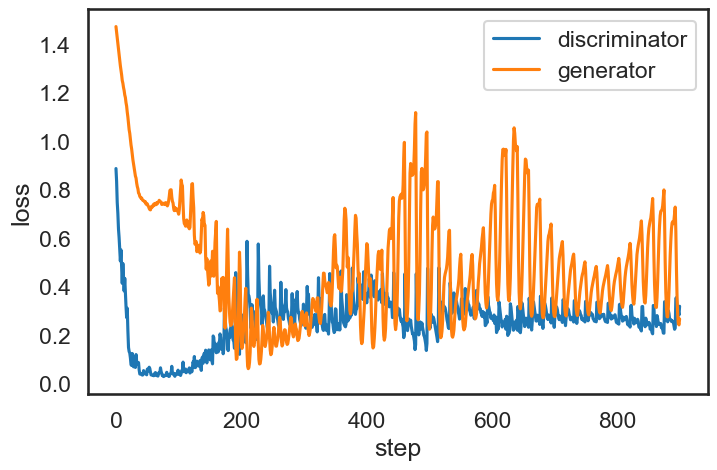

In [79]:
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(x=np.arange(0, len(D_loss_array), 1), y=D_loss_array, label='discriminator')
sns.lineplot(x=np.arange(0, len(D_loss_array), 1), y=G_loss_array, label='generator')
ax.set_xlabel('step')
ax.set_ylabel('loss');

### generated data from trained generator

In [80]:
noise = torch.rand(1, 100, 45)
condition = torch.zeros(1, 100, 1)

In [81]:
torch.cat((noise, condition), axis=2).shape

torch.Size([1, 100, 46])

In [84]:
generated_samples = netG(noise, condition)
generated_data_array = generated_samples.detach().numpy().squeeze()
generated_data_unscaled = scaler.inverse_transform(generated_data_array)

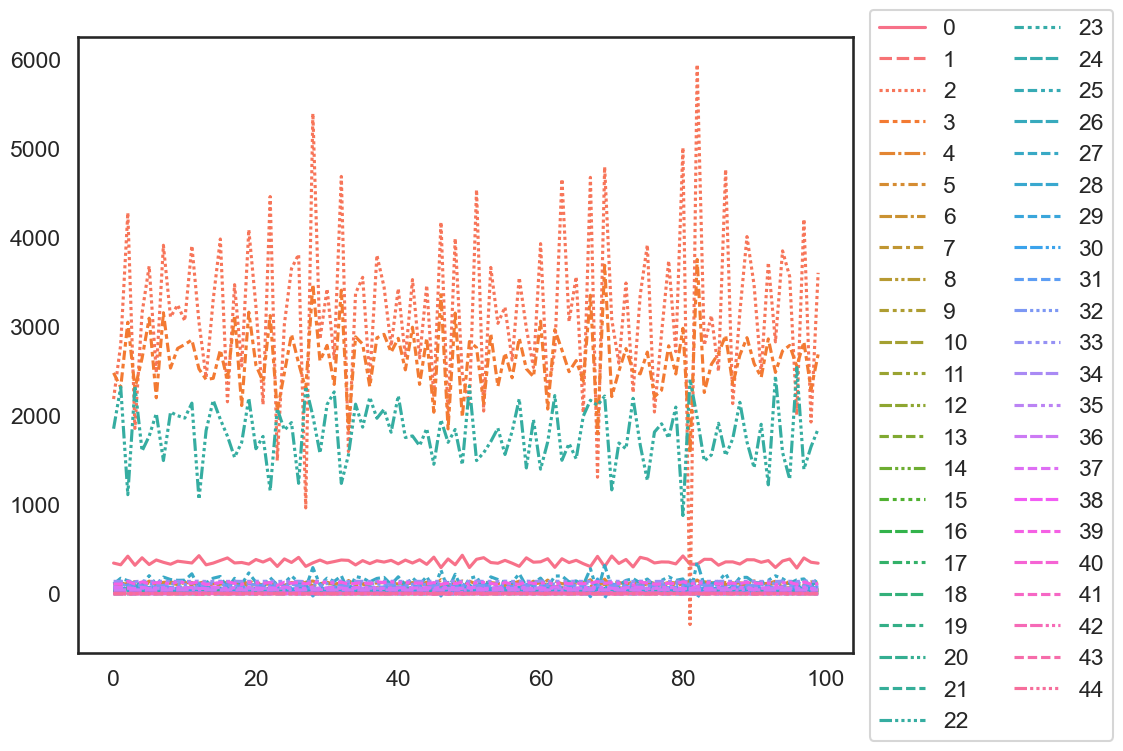

In [85]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(generated_data_unscaled)
ax.legend(loc='right', bbox_to_anchor=(1.35, 0.45), ncol=2)